# CH06. 다층 퍼셉트론과 MNIST (MLP & MNIST) (실습2)

### [1] 실습 진행 관련 설명
다층 퍼셉트론에 대한 실습을 진행하고자 한다.

- Tensorflow 라이브러리를 이용한 방법

본 실습에 사용된 데이터는 MNIST 숫자 손글씨 데이터로 총 6만장의 훈련 데이터와 1만장의 검증 데이터를 통해
텐서플로우 라이브러리로부터 간편한 함수들을 활용하여 다층 퍼셉트론(MLP) 모델이 얼마나 숫자 손글씨를 잘 예측하는지 알아보자.

## [2] 코드 구현의 흐름


-(1) (데이터 측면) MNIST 데이터 불러오기

-(2) (데이터 확인) MNIST 데이터의 특징 확인

-(3) (모델 구현) 텐서플로우 라이브러리로 MLP 모델 구현

-(4) (모델 선언) 손실함수와 경사하강법을 설정하고 모델 선언

-(5) (모델 학습) 선언한 모델와 학습데이터를 바탕으로 학습을 진행

-(6) (성능 평가) 테스트 데이터를 이용하여 학습된 모델에 대한 성능 평가
        
-(7) (모델의 학습 과정 시각화) 정확도와 손실 변화 그래프 관찰


### MNIST 데이터셋과 Tensorflow 라이브러리를 활용한 다층 퍼셉트론의 다중 클래스 분류

In [10]:
'''
필요 라이브러리 선언하기
기존에 많이 사용한 numpy, matplotlib외에 Tesorflow에서 필요로 하는 다양한 함수를 정의한다.
모델을 구성하는 함수, 경사하강법 함수, 손실 함수 및 시각화 함수 등을 선언한다.
'''
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.layers import Flatten, Dense  # 모델의 세부구성과 관련된 함수  ## 참고로 첫번째 실습 시간에는 Input, Dense 사용
from tensorflow.keras.models import Sequential # 모델을 정의하는 함수 ## 참고로 첫번째 실습 시간에는 Model 사용
from tensorflow.keras.optimizers import SGD # 경사하강법 함수
from tensorflow.keras.losses import SparseCategoricalCrossentropy # 손실함수 정의 ## 참고로 첫번째 실습 시간에는 BinaryCrossentropy 사용
from tensorflow.keras.utils import plot_model # 시각화 함수

아래 코드는 GPU를 활용하기 위한 코드이다.

"try" "except"  프로그램 동작 중 발생하는 예외 상황을 처리하기 위한 방법이다.

위 방법을 통해서 사용가능한 GPU가 없다면 오류를 출력한다.

In [11]:
'''
GPU 사용 선언하기
기존 실습에서 사용한 데이터와 다르게 실제 학습에 사용되는 데이터는 그 수와 크기가 매우크다.
따라서 병렬처리 연산이 가능한 GPU를 통한 학습이 권장된다.
'''
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.list_physical_devices('GPU')
    except RuntimeError as e:
        print(e)


**MNIST 데이터**

- MNIST dataset : Modified National Institute of Standards and Technology


손글씨 숫자 분류 데이터셋으로, 머신러닝과 딥러닝 모델의 교육에 주로 사용되는 표준 데이터 세트를 의미한다.

0 ~ 9까지 10개 클래스의 28 * 28 픽셀 흑백 이미지로 구성되며, 60,000개의 훈련 이미지와 10,000개의 테스트 이미지로 구성되어 있다.

In [12]:
'''
(1) (데이터 측면) 데이터 불러오기.
MNIST 숫자 데이터
해당 데이터셋은 train, test 데이터가 자체적으로 분류되어 있어 특별한 함수를 사용하지 않아도 된다.
처음 실행하는 경우 해당 MNIST를 자동으로 다운받는 기능도 제공한다.
'''
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train, return_counts = True))  # 데이터에 각 클래스가 몇개 포함되어 있는지 확인
print(np.unique(y_test, return_counts = True))

(60000, 28, 28)
(10000, 28, 28)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))


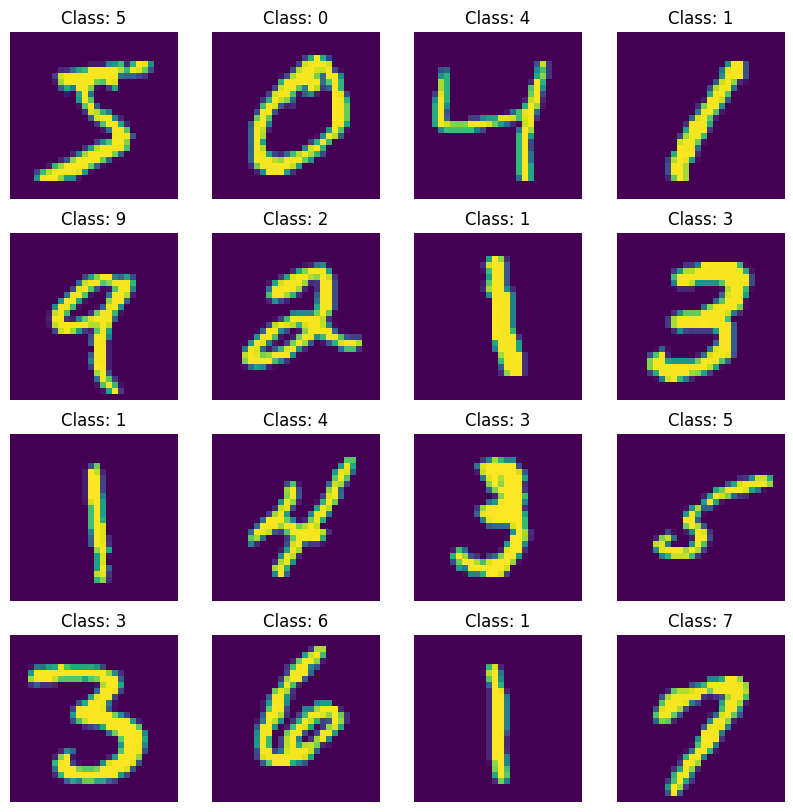

In [13]:
'''
(2) (데이터 확인) MNIST 데이터의 특징 확인
데이터 시각화를 통해서 MNIST 데이터가 어떤 특징을 가지고 있는지,
이미지화 하면 어떤 모양을 가지는지 확인해보자.
'''
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
images, labels = X_train[:16], y_train[:16]
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {class_names[labels[i]]}")
    plt.axis("off")

**모델 구현**

은닉층의 개수 및 각 노드는 실습자가 원하는 수로 정의 가능하다. 해당 실습에서는 두개의 은닉층과 각각 600개, 500개의 노드로 구성된 다층 퍼셉트론을 구현한다.

In [14]:
'''
(3) (모델 구현) 텐서플로우 라이브러리로 MLP 모델 구현
sklearn보다는 조금 더 자세하기 원하는 형태로 모델의 구현이 가능하며,
각 층마다 사용할 활성화 함수나 노드의 선언이 가능하다.

Sequential, Dense 설명 :
   - 연속적인 입력(Sequential Input)으로부터 연속적인 출력(Sequential Output)을 생성하는 모델을 만들어냄
   - MLP의 은닉층과 출력층을 구성하는 Dense 함수가 순차적으로 쌓여가는 모델 설계의 과정을 의미하는 함수

Flatten :
   - Input 함수 대신에 사용되는 것으로 이미지의 픽셀들이 1차원 배열로 각각 하나씩 입력노드에 매칭되도록 도와줌
   - 즉, 28 * 28 픽셀 데이터를 784개의 입력노드에 매칭 시켜주기 위한 함수
'''

model = tf.keras.models.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(600, activation='relu'),
    Dense(500, activation='relu'),
    Dense(10, activation='softmax')
])

In [15]:
'''
(4) (학습 과정) 손실함수와 경사하강법을 설정하고 모델을 학습
손실함수와 경사하강법에 사용될 함수를 정의한다.
어떤 함수를 사용할 것인지 직접 선언해주어야하나, Tensorflow 라이브러리 내에 구현되어 있다.
모델 구성이 완료되면, 모델을 컴파일하고, 완성된 모델의 형태를 요약확인 가능하다.
'''

loss = SparseCategoricalCrossentropy()
optimizer = SGD(learning_rate=0.0001)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 600)               471000    
                                                                 
 dense_1 (Dense)             (None, 500)               300500    
                                                                 
 dense_2 (Dense)             (None, 10)                5010      
                                                                 
Total params: 776510 (2.96 MB)
Trainable params: 776510 (2.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
'''
(5) (모델 학습) 선언한 모델와 학습데이터를 바탕으로 학습을 진행
sklearn에서의 실습과 마찬가지로 Tensorflow도 설정한 모델에 fit함수를 통해서 학습이 가능하다.
'''
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
469/469 [==============================] - 7s 4ms/step - loss: 5.8181 - accuracy: 0.7998 - val_loss: 2.6922 - val_accuracy: 0.8781
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 2.2990 - accuracy: 0.8913 - val_loss: 2.0185 - val_accuracy: 0.8994
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 1.6306 - accuracy: 0.9127 - val_loss: 1.6852 - val_accuracy: 0.9086
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 1.2760 - accuracy: 0.9244 - val_loss: 1.5033 - val_accuracy: 0.9145
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 1.0377 - accuracy: 0.9337 - val_loss: 1.3547 - val_accuracy: 0.9194
Epoch 6/50
469/469 [==============================] - 2s 3ms/step - loss: 0.8578 - accuracy: 0.9407 - val_loss: 1.2765 - val_accuracy: 0.9224
Epoch 7/50
469/469 [==============================] - 2s 3ms/step - loss: 0.7326 - accuracy: 0.9455 - val_loss: 1.1750 - val_accuracy: 0.9245
Epoch 


### 모델 평가

모델이 학습을 모두 완료했다면, 테스트 데이터를 통해 얼마나 잘 맞추는지 검증한다.

79/79 [==============================] - 0s 2ms/step
* Metrics
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.92      0.93      0.93      1032
           3       0.91      0.92      0.92      1010
           4       0.93      0.94      0.93       982
           5       0.90      0.93      0.92       892
           6       0.95      0.94      0.94       958
           7       0.95      0.93      0.94      1028
           8       0.93      0.91      0.92       974
           9       0.93      0.93      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

* Confusion matrix


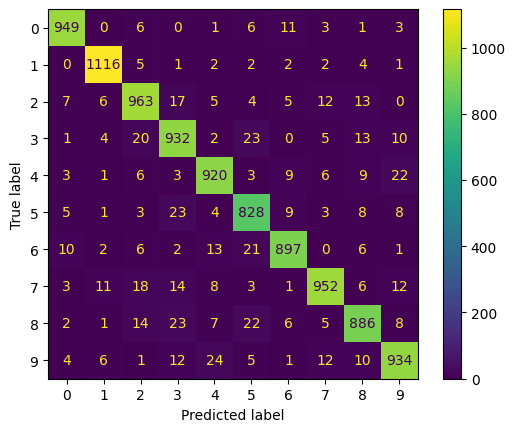

In [17]:
'''
(6) (성능 평가) 테스트 데이터를 이용하여 학습된 모델에 대한 성능 평가
학습이 완료되었으면, 테스트 데이터를 통해서 결과물을 확인한다.
이후 정확도와 혼동 행렬을 통해 결과를 확인하자.
'''
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test, batch_size=128)
pred_class = np.argmax(y_pred, axis=1)

print("* Metrics")
print(classification_report(y_test, pred_class, zero_division=0))

print("* Confusion matrix")
cf = confusion_matrix(y_test, pred_class)
ConfusionMatrixDisplay(cf).plot()

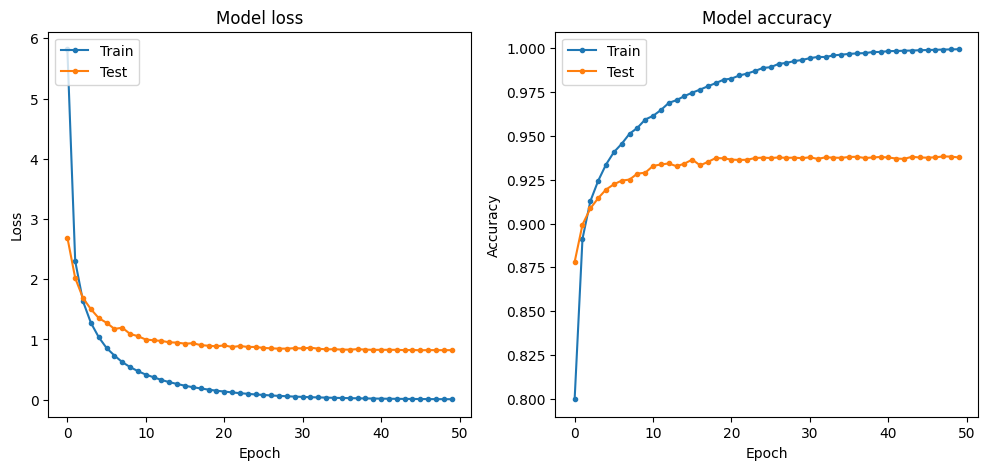

In [18]:
'''
(7) (모델의 학습 과정 시각화) 정확도와 손실 변화 그래프 관찰
추가로 학습의 과정에서 각 단계별 정확도와 손실 함수의 변화를 확인 할 수 있다.
일반적으로 해당 그래프를 보면서 각 단계별 학습이 잘 이루어지고 있는지 확인이 가능하다.
'''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 훈련 및 테스트 과정 시각화 (손실)
ax1.plot(history.history['loss'],marker = '.', label = "Train loss")
ax1.plot(history.history['val_loss'],marker = '.', label = "Valid loss")
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(['Train', 'Test'], loc='upper left')

# 훈련 및 테스트 과정 시각화 (정확도)
ax2.plot(history.history['accuracy'],marker = '.', label = "Train accuracy")
ax2.plot(history.history['val_accuracy'],marker = '.', label = "Valid accuracy")
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(['Train', 'Test'], loc='upper left')

plt.show()